# Import the Required Libs

In [1]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import Callback, EarlyStopping

## Load and Process the Data

In [2]:
train_df = pd.read_csv('Genre Classification Dataset/train_data.txt', sep=":::", header=None, engine='python')
test_df = pd.read_csv('Genre Classification Dataset/test_data.txt', sep=":::", header=None, engine='python')
train_df.columns=['id','title','genre','description']
test_df.columns=['id','title', 'description']
train_df.head(10)

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
5,6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...
6,7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
7,8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
8,9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss..."
9,10,Spirits (2014/I),horror,Four high school students embark on a terrify...


In [3]:
test_df.head(10)

,id,title,description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...
9,10,Press (2011),Press is a story of young people overwhelmed ...


In [4]:
train_df.describe()

,id
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [6]:
train_df.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

## Data Visuals

C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


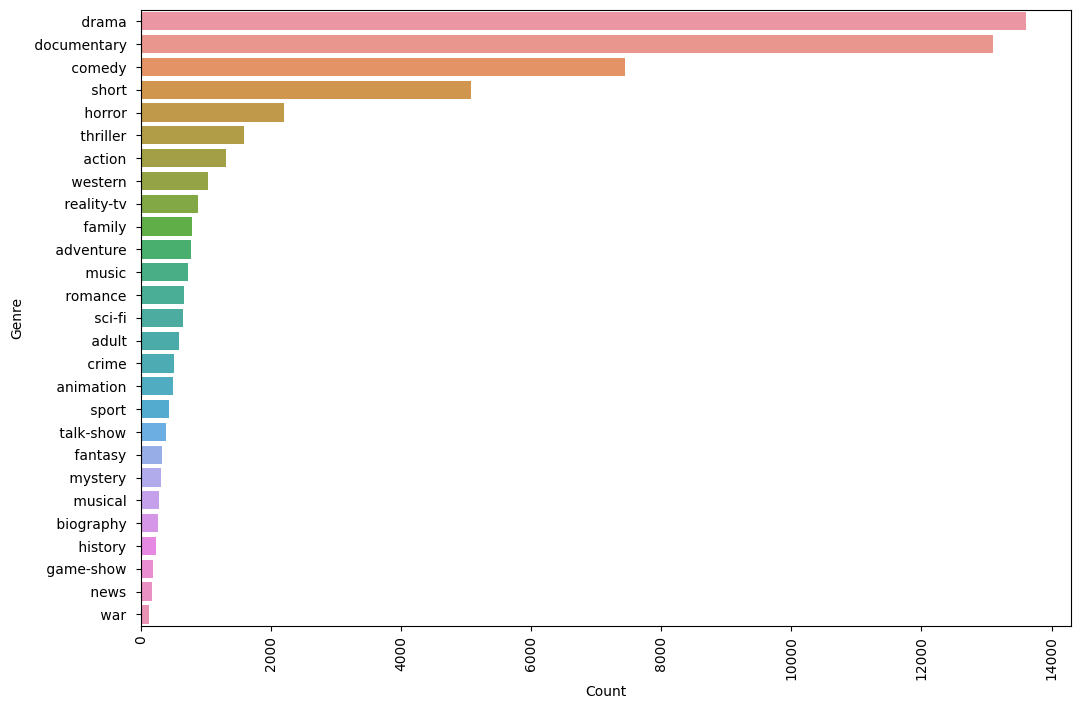

In [7]:
plt.figure(figsize = (12,8))
counts = train_df.genre.value_counts()
sns.barplot(x = counts, y = counts.index, orient='h')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.xticks(rotation=90);

C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000'),
  Text(12000.0, 0, '12000'),
  Text(14000.0, 0, '14000'),
  Text(16000.0, 0, '16000')])

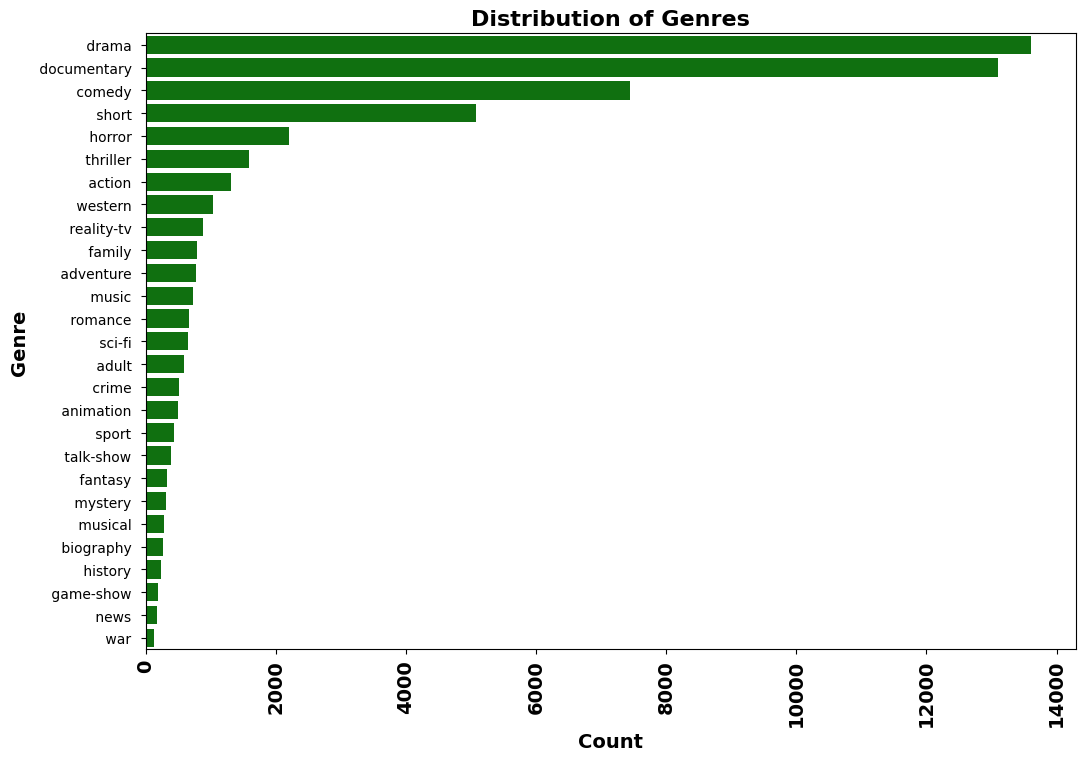

In [8]:
plt.figure(figsize=(12,8))
counts = train_df.genre.value_counts()
sns.barplot(x=counts, y=counts.index, color='green')
plt.ylabel('Genre' ,fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')

C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='genre'>

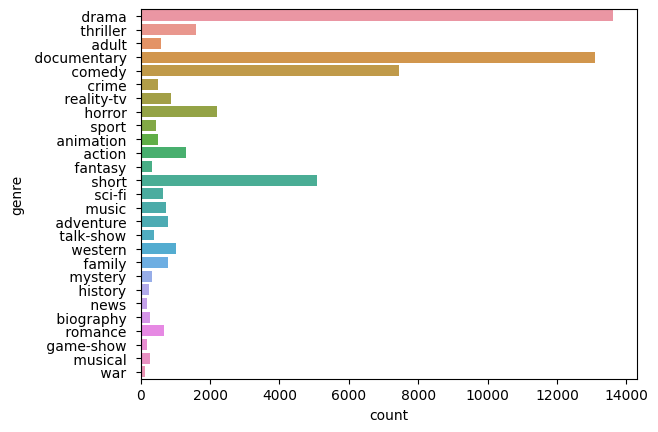

In [9]:
sns.countplot(y='genre',data=train_df)

In [10]:
train_df['length']=train_df['description'].apply(len)
train_df.head()

,id,title,genre,description,length
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


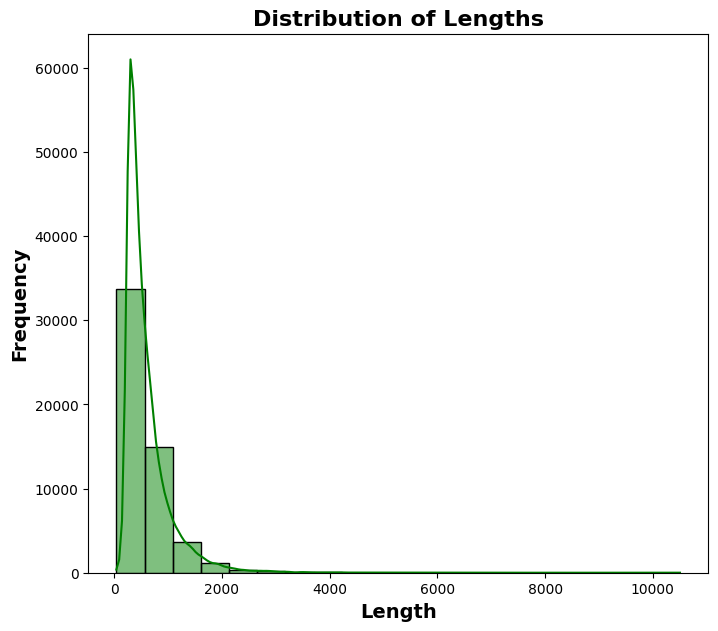

In [11]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_df, x='length', bins=20, kde=True, color='green')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

## Data Cleaning

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower()                                  # lower-case all characters
    text = re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = re.sub(f'[{string.digits}]',' ',text)  # remove digits
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # remove stopwords and stem other words
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations


# Test your cleaning function
input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text: {input_text}')
print(f'Cleaned text: {clean_text(input_text)}')

Original text: Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text: certain get dram boost hello bye iem


In [13]:
train_df['Text_cleaning'] = train_df.description.apply(clean_text)
test_df['Text_cleaning'] = test_df.description.apply(clean_text)
train_df.head()

,id,title,genre,description,length,Text_cleaning
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [14]:
train_df['length_Text_cleaning']=train_df['Text_cleaning'].apply(len)
train_df.head()

,id,title,genre,description,length,Text_cleaning,length_Text_cleaning
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


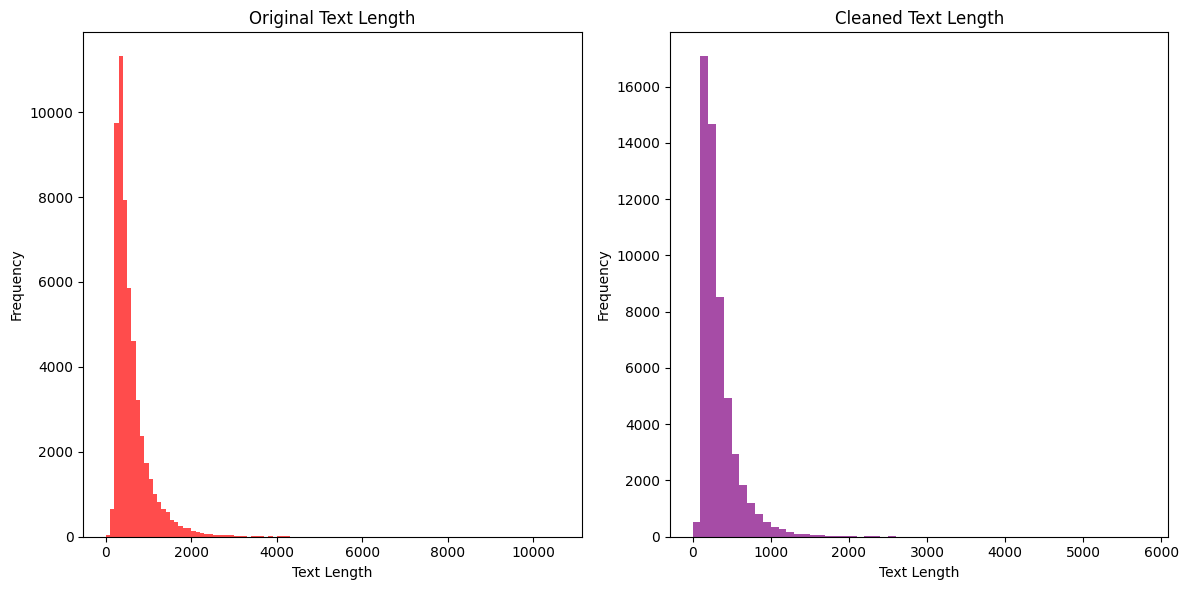

In [15]:
# Create histograms for text length before and after cleaning
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_df['description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='red', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_df['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='purple', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
(train_df['length_Text_cleaning']>2000).value_counts()

length_Text_cleaning
False    54131
True        83
Name: count, dtype: int64

In [17]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_df))
filt=train_df['length_Text_cleaning']>2000
train_df.drop(train_df[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_df))
print(f'Removed rows: {filt.sum()}')


Dataframe size (before removal):  54214
Dataframe size (after removal):  54131
Removed rows: 83


C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


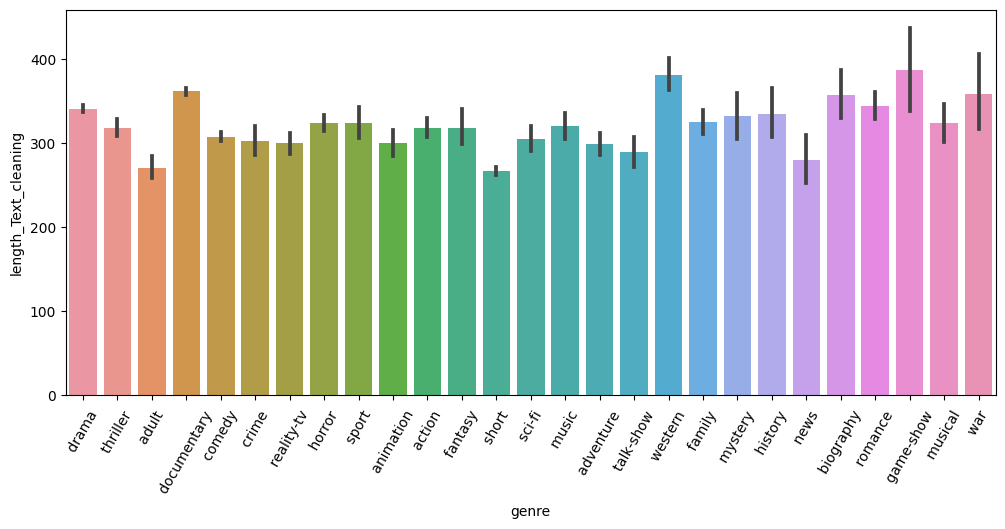

C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


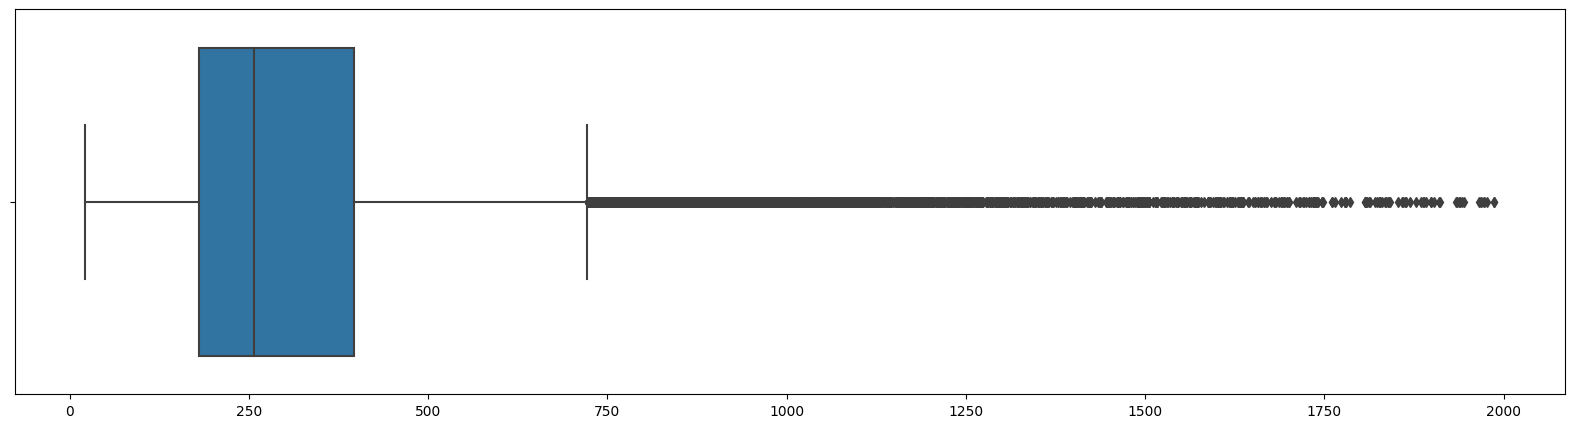

In [18]:
plt.figure(figsize=(12,5))
sns.barplot(x='genre',y='length_Text_cleaning',data=train_df)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=train_df['length_Text_cleaning'].values,hue='genre',data=train_df)
plt.show()

In [19]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['Text_cleaning'].values)

In [20]:
test_solution_df = pd.read_csv('Genre Classification Dataset/test_data_solution.txt', sep=":::", header=None, engine='python')
test_solution_df.columns= ['id','title','genre','description']
test_solution_df.head()

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [21]:
X = tokenizer.texts_to_sequences(train_df['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_df['genre']).values

X_test = tokenizer.texts_to_sequences(test_df['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_solution_df['genre']).values

## Model Training

In [22]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
my_callbacks  = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto')]
model_history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

Epoch 1/6
1692/1692 [==============================] - 73260s 43s/step - loss: 1.9748 - accuracy: 0.4249 - val_loss: 1.6772 - val_accuracy: 0.5118
Epoch 2/6
1692/1692 [==============================] - 818s 484ms/step - loss: 1.4488 - accuracy: 0.5818 - val_loss: 1.5563 - val_accuracy: 0.5404
Epoch 3/6
1692/1692 [==============================] - 727s 430ms/step - loss: 1.1250 - accuracy: 0.6744 - val_loss: 1.5933 - val_accuracy: 0.5473
Epoch 4/6
1692/1692 [==============================] - 791s 467ms/step - loss: 0.8422 - accuracy: 0.7548 - val_loss: 1.6971 - val_accuracy: 0.5323


# Saving the Model

In [24]:
model.save('movie-genre-classification.h5')

C:\Dev\Movie Genre Classification\moviegenreclassification\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Accuracy and Loss

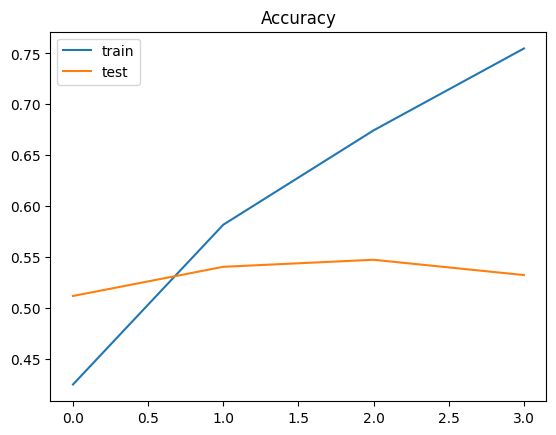

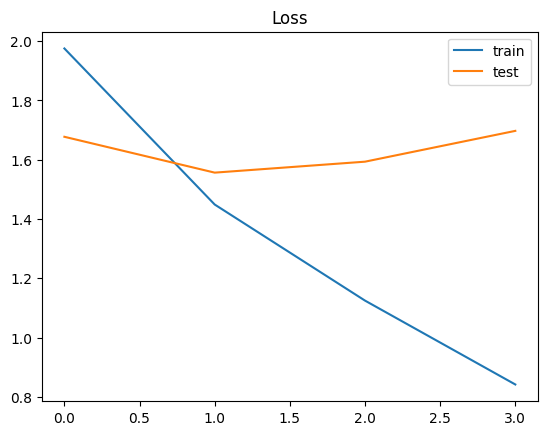

In [25]:
# Plotting Accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show();

# Test Accuracy 

In [26]:
results = model.evaluate(X_test, y_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.69710
Test Accuracy: 53.23%
